In [1]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

# warnings.filterwarnings("ignore")
warnings.filterwarnings(action='once')

import matplotlib.pyplot as plt

%matplotlib inline
# plots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    classification_report,
    f1_score,
    plot_confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tensorflow import keras
# from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB7, EfficientNetB4
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential

# keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm

In [3]:
PATH = "/app/_data/"
BATCH_SIZE = 16
SEED = 1488
IMAGE_SIZE = (380, 380)
NUM_CLASSES = 6
INPUT_SHAPE = (380, 380, 3)
IMG_PATH = '/app/_data/train_images/'
# MODEL_PATH = '/app/_data/models/effnet7_2_6cl_frozen_40ep_42.h5'

In [7]:
labels = pd.read_csv(PATH+'train_crop.csv')

In [8]:
sample_submission = pd.read_csv(PATH + "sample_submission.csv")

In [9]:
labels = labels.join(labels["labels"].str.get_dummies(sep=" "))

In [10]:
labels.head(1)

image  ... scab
0  800113bb65efe69e.jpg  ...    0

[1 rows x 8 columns]

In [11]:
feature_columns = labels.columns[2:].tolist()
feature_columns

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [8]:
train_df, valid_df = train_test_split(
    labels, train_size=0.8, random_state=SEED1, stratify=labels["labels"]
)

In [53]:
train_datagen = ImageDataGenerator(
    validation_split=0.2, dtype = 'int8'
)
train = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=IMG_PATH,
    x_col="image",
    y_col=feature_columns,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="training",
    seed=SEED,
    interpolation="bicubic",
)

Found 14800 validated image filenames.


In [54]:
t,v = next(train)
    

In [55]:
type(t[0][0][0][0])
t[0][0][0][0]

numpy.float32

108.0

In [56]:
v[0]

array([0, 0, 0, 0, 0, 1])

In [15]:
train2=ImageDataGenerator().flow_from_dataframe(
    dataframe=train_df ,
    directory=IMG_PATH,
    x_col="image",
    y_col=feature_columns,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    seed=SEED1,
    interpolation="bicubic",
)

Found 14800 validated image filenames.


In [16]:
valid_datagen = ImageDataGenerator(
    validation_split=0.2,

)
valid = valid_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=IMG_PATH,
    x_col="image",
    y_col=feature_columns,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="validation",
    seed=SEED2,
    classes=feature_columns,
    interpolation="bicubic",
    shuffle=True,

)

Found 3700 validated image filenames.


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/dataframe_iterator.py:219: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn('`classes` will be ignored given the class_mode="{}"'


In [17]:
valid2=ImageDataGenerator().flow_from_dataframe(
    dataframe=valid_df ,
    directory=IMG_PATH,
    x_col="image",
    y_col=feature_columns,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    seed=SEED2,
    interpolation="bicubic",
)

Found 3700 validated image filenames.


In [18]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH + "test_images/",
    x_col="image",
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed=SEED2,
    shuffle=False,
    interpolation="bicubic",
)

Found 3 validated image filenames.


In [19]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

In [31]:
data_augmentation = keras.Sequential(
    [
#         keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#         keras.layers.experimental.preprocessing.RandomHeight(0.1),
#         keras.layers.experimental.preprocessing.RandomWidth(0.1),
#         keras.layers.experimental.preprocessing.RandomRotation(0.15),
#         keras.layers.experimental.preprocessing.RandomZoom(0.25, 0.25),
        keras.layers.experimental.preprocessing.RandomContrast(factor=0.05),
        keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2,width_factor=0.2),
        keras.layers.experimental.preprocessing.PreprocessingLayer.
    ]
)

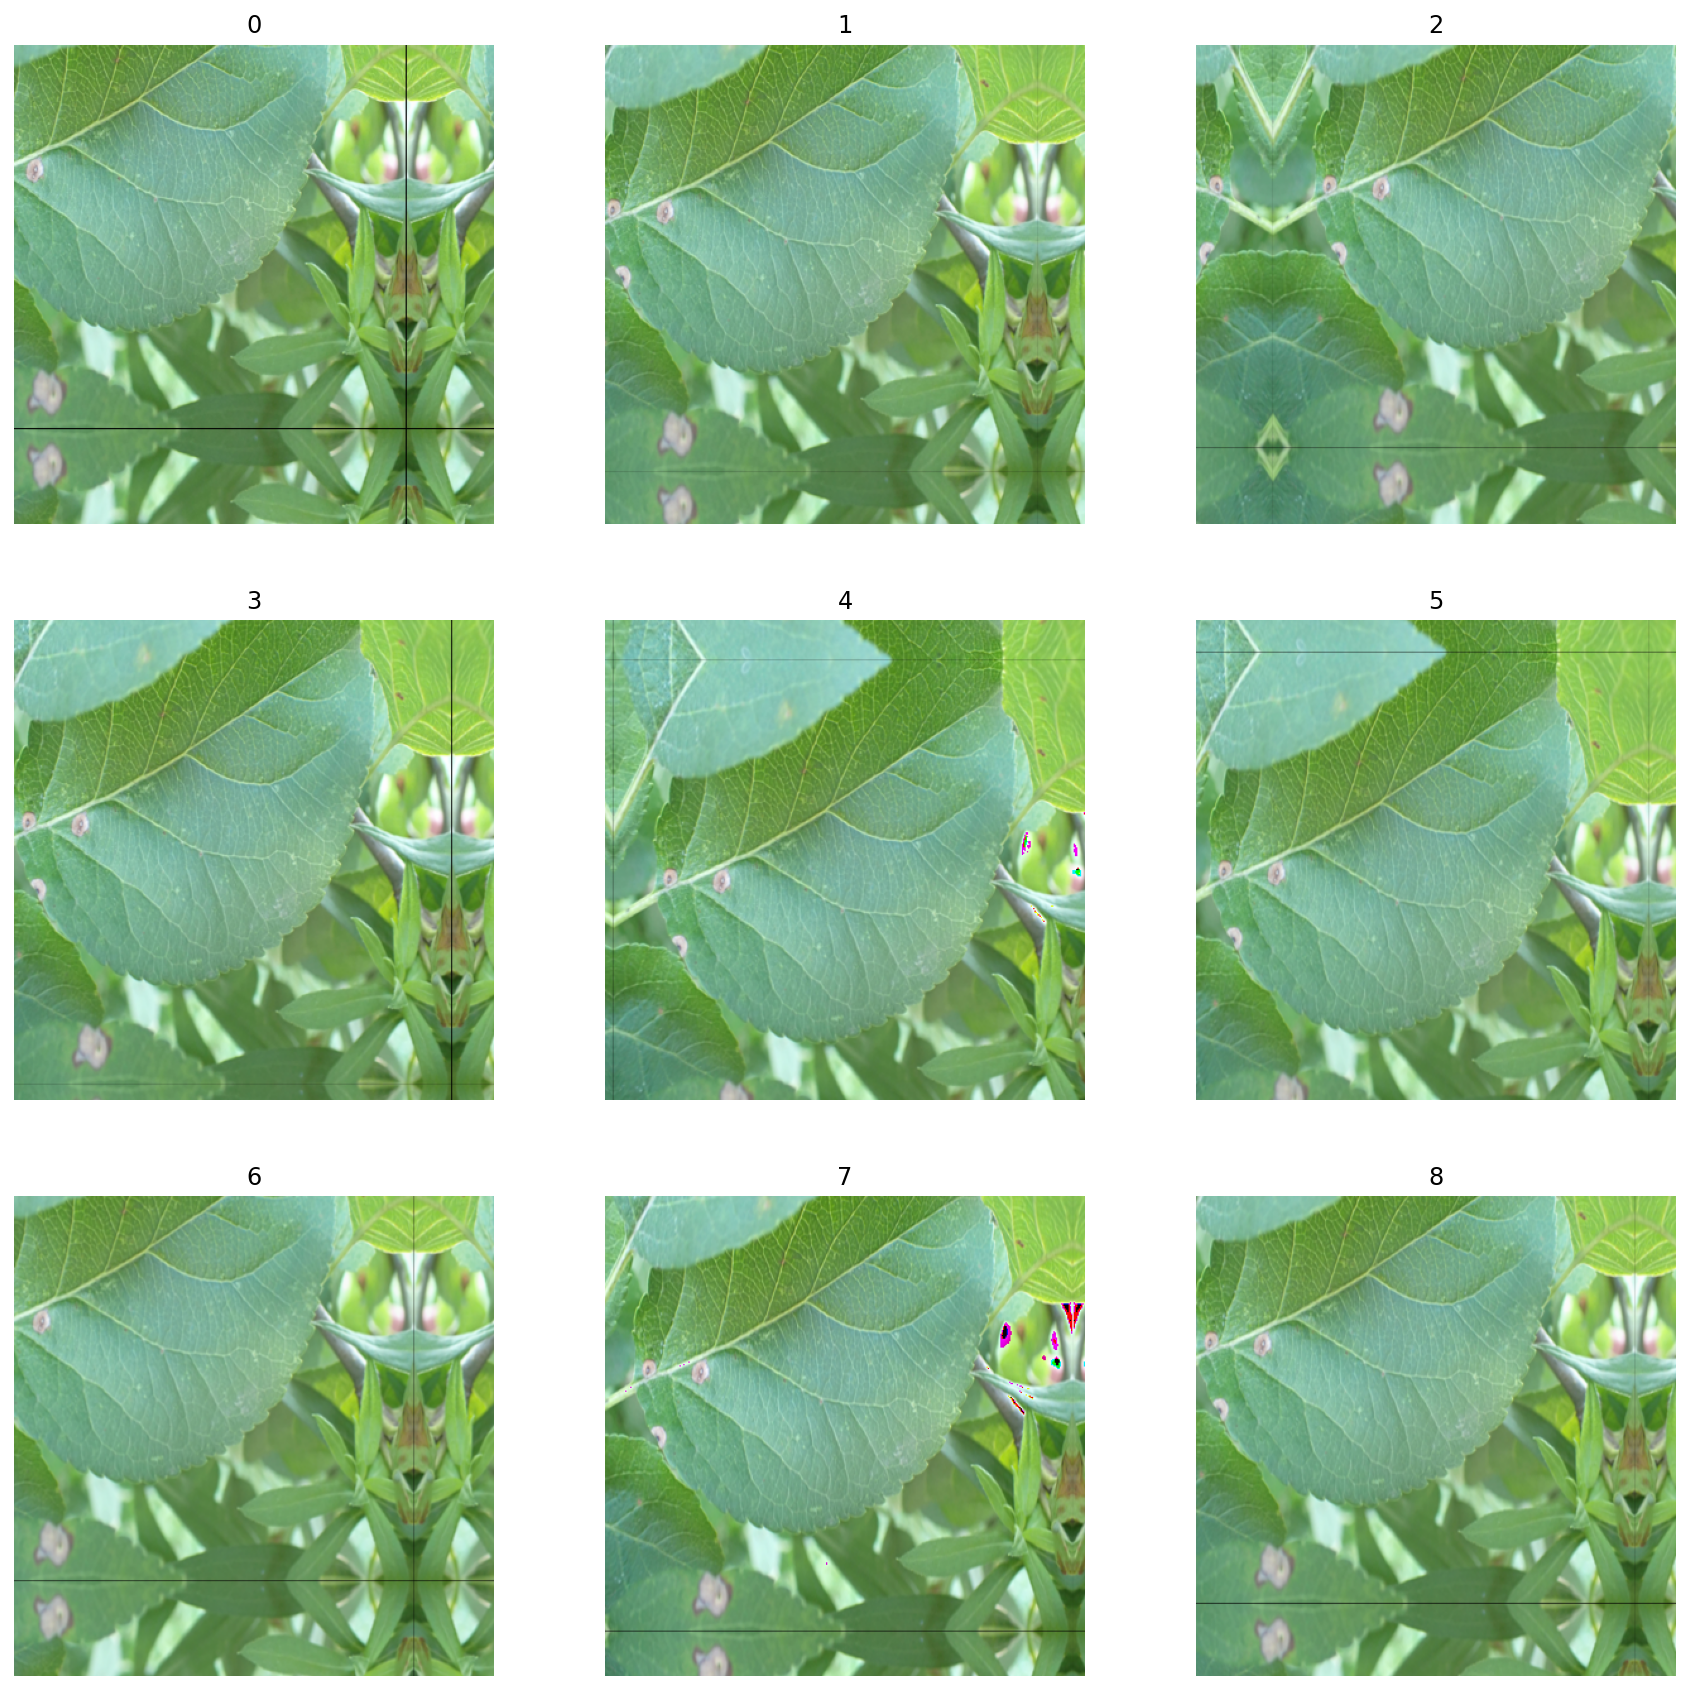

In [32]:
features, target = next(train)
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_img = data_augmentation(tf.expand_dims(features[0], axis=0))
    plt.imshow(aug_img[0].numpy().astype("uint8"))
    plt.title(i)
    plt.axis("off")
plt.show();

In [22]:
# tf.keras.mixed_precision.set_global_policy('mixed_float16')
policy = keras.mixed_precision.experimental.Policy('mixed_float16')
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 5000, compute capability 7.5


In [23]:
# def scheduler(epoch, lr):
#     if epoch < 5:
#         return lr
#     elif 5 <= epoch < 20:
#         return 0.0005
#     else:
#         return 0.0001

In [24]:
callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss',
            patience=10, restore_best_weights=True, verbose=1),
#         keras.callbacks.LearningRateScheduler(schedule = scheduler, verbose=1)
        ]

In [25]:
# def build_model(num_classes):
#     inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#     x = img_augmentation(inputs)
#     model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

#     # Freeze the pretrained weights
#     model.trainable = False

#     # Rebuild top
#     x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
#     x = layers.BatchNormalization()(x)

#     top_dropout_rate = 0.2
#     x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#     outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

#     # Compile
#     model = tf.keras.Model(inputs, outputs, name="EfficientNet")
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
#     model.compile(
#         optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
#     )
#     return model

In [26]:
# inputs = keras.layers.Input(shape=INPUT_SHAPE)
# x = data_augmentation(inputs)
# model = keras.applications.EfficientNetB7(weights="imagenet", include_top=False,  input_tensor=x)
# model.trainable = False

# x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
# x = keras.layers.Flatten(name="flatten")(x)
# outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

In [27]:
# inputs = keras.Input(shape=INPUT_SHAPE)
# x = data_augmentation(inputs)
# x = keras.applications.EfficientNetB7(weights="imagenet", include_top=False)(x)
# x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
# x = keras.layers.Flatten(name="flatten")(x)
# outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

In [28]:
# model.compile(
#     loss="binary_crossentropy",
#     optimizer=Adam(lr=0.0005),
#     metrics=['acc',
#         keras.metrics.Recall(),
#         keras.metrics.Precision(),
#         tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="micro"),
#     ],
# )

In [29]:
# history = model.fit(
#     train,
#     validation_data=valid,
#     epochs=20,
#     batch_size=BATCH_SIZE,
#     verbose=1,
#     use_multiprocessing=True,
#     callbacks = callbacks
# )

In [30]:
# history_effnet7_2_6cl_frozen_40epseed_42 = pd.DataFrame(history.history)
# history_effnet7_2_6cl_frozen_40epseed_42.to_csv("history_effnet7_2_6cl_frozen_40epseed_42.csv")

In [31]:
# model.save("/app/_data/models/effnet7_2_6cl_frozen_40ep_42.h5")

In [32]:
# import shutil
# shutil.make_archive('base_model_0001_nearest', 'zip','/app/_data/models/base_model_0001/')

In [33]:
model2 = keras.models.load_model("/app/_data/models/effnet7_2_6cl_frozen_40ep_42.h5")

In [34]:
# plot_curves(history, loss=True)

In [35]:
# plot_curves(history)

In [36]:
# model.evaluate(valid)

In [37]:
model2.trainable=True

In [38]:
len(model2.trainable_weights)
len(model2.weights)

711

1040

In [ ]:
history2 = model2.fit(
    train2,
    validation_data=valid2,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks = callbacks
)

Epoch 1/20
925/925 [==============================] - 3573s 4s/step - loss: 0.1666 - acc: 0.8349 - recall: 0.7565 - precision: 0.8627 - f1_score: 0.8304 - val_loss: 0.1639 - val_acc: 0.8370 - val_recall: 0.7787 - val_precision: 0.8532 - val_f1_score: 0.8260
Epoch 2/20
925/925 [==============================] - 3547s 4s/step - loss: 0.1665 - acc: 0.8355 - recall: 0.7553 - precision: 0.8625 - f1_score: 0.8319 - val_loss: 0.1627 - val_acc: 0.8392 - val_recall: 0.8036 - val_precision: 0.8456 - val_f1_score: 0.8311
Epoch 3/20
925/925 [==============================] - 3552s 4s/step - loss: 0.1676 - acc: 0.8330 - recall: 0.7536 - precision: 0.8584 - f1_score: 0.8297 - val_loss: 0.1697 - val_acc: 0.8303 - val_recall: 0.7712 - val_precision: 0.8475 - val_f1_score: 0.8196
Epoch 4/20
925/925 [==============================] - 3580s 4s/step - loss: 0.1669 - acc: 0.8332 - recall: 0.7567 - precision: 0.8635 - f1_score: 0.8295 - val_loss: 0.1594 - val_acc: 0.8454 - val_recall: 0.7919 - val_precision

In [ ]:
model.save("/app/_data/models/effnet7_2_6cl_from_frozezen_20ep.h5")